In [14]:
TITLE = "mnist/vistion-transfomer"
print(f"Active {TITLE}")

Active mnist/vistion-transfomer


In [1]:
import argparse
import time
import numpy as np
import models
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import transforms
from timm.optim import create_optimizer
from timm.utils import accuracy, AverageMeter
from datasets.mnist.mnist_data import get_mnist_dataset
from util.show_images import ShowImages
from util.visualization import Visualization
from util.notification import Notification
from util.custom_time import Time
from util.path_functions import PathFunctions

path_functions_instance = PathFunctions()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Active PathFunctions instance created
Active PathFunctions instance created


In [2]:
SAVEFILENAME = "mnist-vit"
SAVEWEIGHTPATH = f"dev/result/weight/{SAVEFILENAME}.pth"

In [3]:
def get_args_parser():
  parser = argparse.ArgumentParser(description="Training Config")
  parser.add_argument('--batch-size', default=64, type=int)
  parser.add_argument('--epochs', default=300, type=int)
  parser.add_argument('--device', default='cuda:0',
                        help='device to use for training / testing')
  parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
  parser.add_argument('--resize', default=224, type=int)

  # Model parameters
  parser.add_argument("--input-size", default=None, nargs=3, type=int, help='images input size')

  # Optimizer parameters
  parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                      help='Optimizer (default: "adamw"')
  parser.add_argument('--opt-eps', default=1e-8, type=float, metavar='EPSILON',
                      help='Optimizer Epsilon (default: 1e-8)')
  parser.add_argument('--opt-betas', default=None, type=float, nargs='+', metavar='BETA',
                      help='Optimizer Betas (default: None, use opt default)')
  parser.add_argument('--clip-grad', type=float, default=None, metavar='NORM',
                      help='Clip gradient norm (default: None, no clipping)')
  parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                      help='SGD momentum (default: 0.9)')
  parser.add_argument('--weight-decay', type=float, default=0.05,
                      help='weight decay (default: 0.05)')

  # Learning rate schedule parameters
  parser.add_argument("--lr", type=float, default=0.01, metavar="LR")
  
  return parser


In [4]:
args = get_args_parser().parse_args(["--input-size", "3", "224", "224"])
args.epochs = 30
args.resize = 224
args.lr = 0.001
Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = args.epochs
BATCH_SIZE = args.batch_size
RESEIZE = args.resize

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 1チャンネルを3チャンネルに変換
    transforms.Resize((RESEIZE, RESEIZE)),  # ViTモデルは大きな画像が必要
    transforms.ToTensor()
])
train_data_loader = get_mnist_dataset(train=True, transform=transform, batch_size=BATCH_SIZE)
test_data_loader = get_mnist_dataset(train=False, transform=transform, batch_size=BATCH_SIZE)
examples = next(iter(train_data_loader))


Active ShowImages instance created
Shape: torch.Size([3, 224, 224])


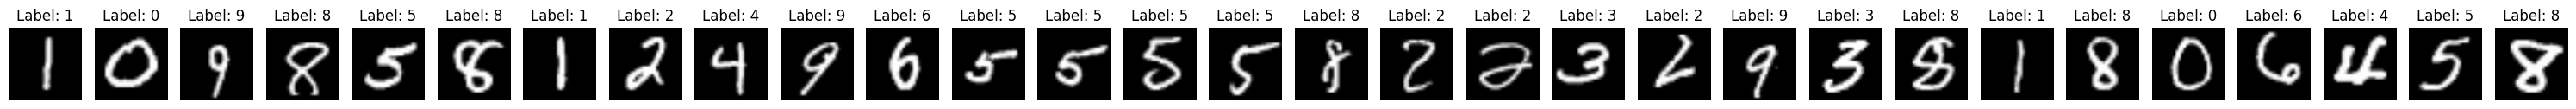

In [6]:
show_images_instance = ShowImages()

show_images_instance.show_images_loader(dataset_lodaer=train_data_loader, num_images_to_display=30)

In [7]:
# model = models.vit_base_16_224(pretrained=True, num_classes=10)
model = models.vit_tiny_16_224(pretrained=True, num_classes=10, img_size=RESEIZE)
# from torchinfo import summary

# summary(model, input_size=(16, 3, 224, 224))
# model = models.vit_custom()
# print(model)

In [8]:
model.to(args.device)
train_loss_fn = nn.CrossEntropyLoss().cuda()
validate_loss_fn = nn.CrossEntropyLoss().cuda()

optimizer = create_optimizer(args, model)

# Set up the learning rate scheduler (if needed)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [9]:
def convert_seconds(seconds):
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return hours, minutes, seconds

def train_one_epoch(model, loader, optimizer, loss_fn, args):
  batch_time_m = AverageMeter()
  losses_m = AverageMeter()
  accuracy_m = AverageMeter()

  model.train()
  start = time.time()
  print("--Active train--")
  for _, (inputs, labels) in enumerate(loader):
      # 勾配をゼロにリセット
      optimizer.zero_grad()
      # 入力データとラベルをデバイスに移動
      inputs, labels = inputs.to(args.device), labels.to(args.device)
      # モデルに入力データを渡して予測を取得
      outputs = model(inputs)
      # 損失を計算
      loss = loss_fn(outputs, labels)
      # 勾配を計算
      loss.backward()
      # オプティマイザでパラメータを更新
      optimizer.step()

      # 精度の計算
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      accuracy = correct / labels.size(0)
      accuracy_m.update(accuracy, labels.size(0))

      # 更新
      torch.cuda.synchronize()
      losses_m.update(loss.item(), inputs.size(0))
      batch_time_m.update(time.time() - start)
      start = time.time()
  train_accuracy = accuracy_m.avg * 100
  # バッチごとの時間を表示
  # バッチごとの時間を変換
  batch_time_sum_h, batch_time_sum_min, batch_time_sum_sec = convert_seconds(batch_time_m.sum)
  batch_time_avg_h, batch_time_avg_min, batch_time_avg_sec = convert_seconds(batch_time_m.avg)
  print(
      f"Batch Time: {batch_time_sum_h:.0f}h {batch_time_sum_min:.0f}min {batch_time_sum_sec:.4f}sec, "
      f"Batch Time Average: {batch_time_avg_h:.0f}h {batch_time_avg_min:.0f}min {batch_time_avg_sec:.4f}sec"
  )
  print(f"Accuracy: {train_accuracy:.2f}%, Loss: {losses_m.avg}")
  return {
      'accuracy': train_accuracy,
      'loss': losses_m.avg,
      'batch_time_sum': batch_time_m.sum,
      'batch_time_avg': batch_time_m.avg
  }

def test(model, loader, args):
    print('--Active test--')
    accuracy_m = AverageMeter()
    # モデルを評価モードに設定
    model.eval()
    # 勾配を計算しないようにするための torch.no_grad() コンテキストを使用
    with torch.no_grad():
      # データローダーからバッチごとのデータを取得
      for _, (inputs, labels) in enumerate(loader):
        # 入力データとラベルをデバイスに移動
        inputs, labels = inputs.to(args.device), labels.to(args.device)
        # モデルに入力データを渡して予測を取得
        output = model(inputs)
        # 精度の計算
        _, predicted = torch.max(output.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        accuracy_m.update(accuracy, labels.size(0))
    # テスト精度を計算
    test_accuracy = accuracy_m.avg * 100
    print(f"Accuracy: {test_accuracy:.2f}%")
    return {'accuracy': test_accuracy}


In [10]:
train_accuracy_history = []
train_loss_history = []
train_batch_time_history = []
train_batch_time_ave_history = []
test_accuracy_history = []

for epoch in range(args.start_epoch, args.epochs):
    print(f"Epoch [{epoch + 1}/{args.epochs}]")
    train_result = train_one_epoch(model, train_data_loader, optimizer, train_loss_fn, args)
    test_result = test(model, test_data_loader, args)

    # トレーニング結果を保存
    train_accuracy_history.append(train_result['accuracy'])
    train_loss_history.append(train_result['loss'])
    train_batch_time_history.append(train_result['batch_time_sum'])
    train_batch_time_ave_history.append(train_result['batch_time_avg'])

    # テスト結果を保存
    test_accuracy_history.append(test_result['accuracy'])

final_save_path = path_functions_instance.absolutePath(SAVEWEIGHTPATH) 
torch.save(model.state_dict(), final_save_path)

Epoch [1/30]
--Active train--
Batch Time: 0h 1min 2.9473sec, Batch Time Average: 0h 0min 0.0671sec
Accuracy: 67.49%, Loss: 0.8893015894532204
--Active test--
Accuracy: 93.06%
Epoch [2/30]
--Active train--
Batch Time: 0h 1min 3.9441sec, Batch Time Average: 0h 0min 0.0682sec
Accuracy: 95.71%, Loss: 0.1359374232451121
--Active test--
Accuracy: 97.04%
Epoch [3/30]
--Active train--
Batch Time: 0h 1min 4.2626sec, Batch Time Average: 0h 0min 0.0685sec
Accuracy: 96.96%, Loss: 0.10008599502270421
--Active test--
Accuracy: 97.15%
Epoch [4/30]
--Active train--
Batch Time: 0h 1min 4.5171sec, Batch Time Average: 0h 0min 0.0688sec
Accuracy: 97.40%, Loss: 0.08383171042030056
--Active test--
Accuracy: 95.76%
Epoch [5/30]
--Active train--
Batch Time: 0h 1min 4.3818sec, Batch Time Average: 0h 0min 0.0686sec
Accuracy: 97.59%, Loss: 0.07714142624052862
--Active test--
Accuracy: 98.22%
Epoch [6/30]
--Active train--
Batch Time: 0h 1min 4.3717sec, Batch Time Average: 0h 0min 0.0686sec
Accuracy: 97.85%, Loss:

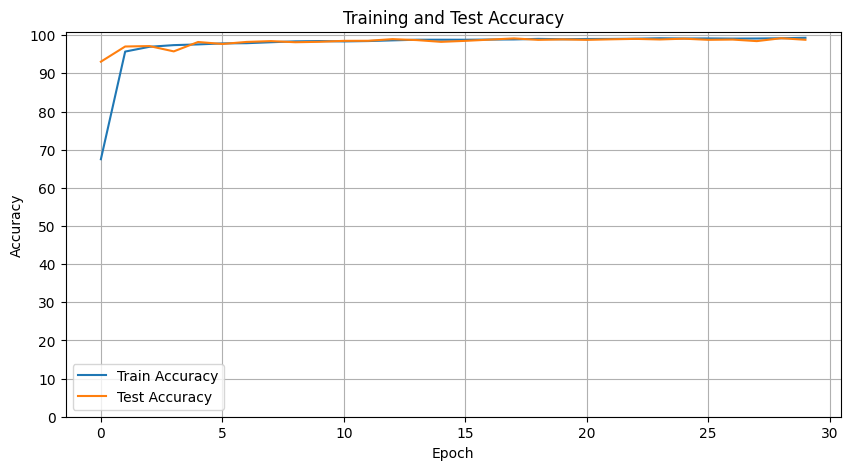

In [11]:
# グラフのx軸にエポック数を+1して1エポック目から始まるように修正
x = list(range(1, args.epochs + 1))
x_ticks = list(range(1, args.epochs + 1, 10))
# グラフのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label="Train Accuracy")
plt.plot(test_accuracy_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.yticks(range(0, 101, 10))
plt.grid(True)
plt.show()

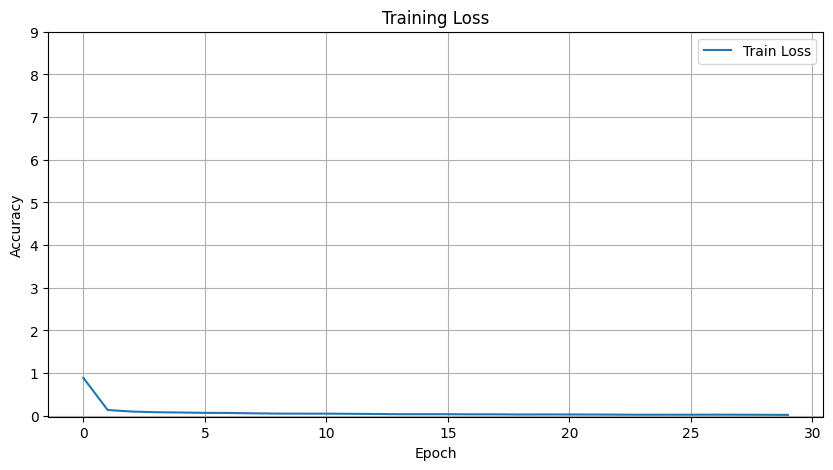

In [12]:
# グラフのx軸にエポック数を+1して1エポック目から始まるように修正
x = list(range(1, args.epochs + 1))
x_ticks = list(range(1, args.epochs + 1, 10))
# グラフのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Loss")
plt.yticks(range(0, 10, 1))
plt.grid(True)
plt.show()

In [15]:
notificationInstants = Notification()
customTimeInstants = Time()
channel="vit-team"
message = (
    f"accuracy: {train_accuracy_history[-1]}%, loss: {train_loss_history[-1]}, accuracy: {test_accuracy_history[-1]}% "
    f"Alltime: {customTimeInstants.convert_time_text(np.sum(train_batch_time_history))}, "
    f"TimeAve: {customTimeInstants.convert_time_text(np.sum(train_batch_time_ave_history))}"
)
notificationInstants.send_slack_notification(message=f"SUCESS: Active {TITLE}", channel=channel)
notificationInstants.send_slack_notification(message=message, channel=channel)

Active Time instance created
Slack notification sent successfully!
Slack notification sent successfully!


-- Active position embedding
Active Visualization instance created


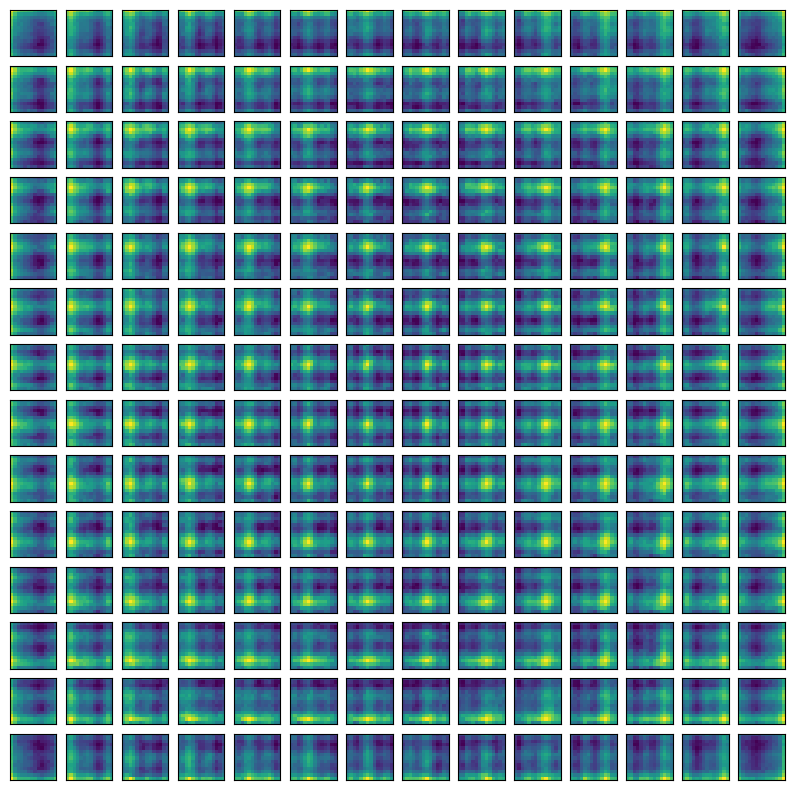

-- Active Attention Map
Active Visualization instance created
BaseImageInfo: (Size: (28, 28), Mode: RGB)
TransformImageInfo: torch.Size([1, 3, 224, 224])
attetionWeightInfo(L, H, N, N): (12, 3, 197, 197)
attetionWeightInfo(L, N, N): (12, 197, 197)
v.shape: (197, 197)
BaseImageInfo: (Size: (28, 28), Mode: RGB)
TransformImageInfo: torch.Size([1, 3, 224, 224])
attetionWeightInfo(L, H, N, N): (12, 3, 197, 197)
attetionWeightInfo(L, N, N): (12, 197, 197)
v.shape: (197, 197)
BaseImageInfo: (Size: (28, 28), Mode: RGB)
TransformImageInfo: torch.Size([1, 3, 224, 224])
attetionWeightInfo(L, H, N, N): (12, 3, 197, 197)
attetionWeightInfo(L, N, N): (12, 197, 197)
v.shape: (197, 197)
BaseImageInfo: (Size: (28, 28), Mode: RGB)
TransformImageInfo: torch.Size([1, 3, 224, 224])
attetionWeightInfo(L, H, N, N): (12, 3, 197, 197)
attetionWeightInfo(L, N, N): (12, 197, 197)
v.shape: (197, 197)
BaseImageInfo: (Size: (28, 28), Mode: RGB)
TransformImageInfo: torch.Size([1, 3, 224, 224])
attetionWeightInfo(L, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BaseImageInfo: (Size: (28, 28), Mode: RGB)
TransformImageInfo: torch.Size([1, 3, 224, 224])
attetionWeightInfo(L, H, N, N): (12, 3, 197, 197)
attetionWeightInfo(L, N, N): (12, 197, 197)
v.shape: (197, 197)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

PDF file saved at: dev/result/image/mnist-vit.pdf


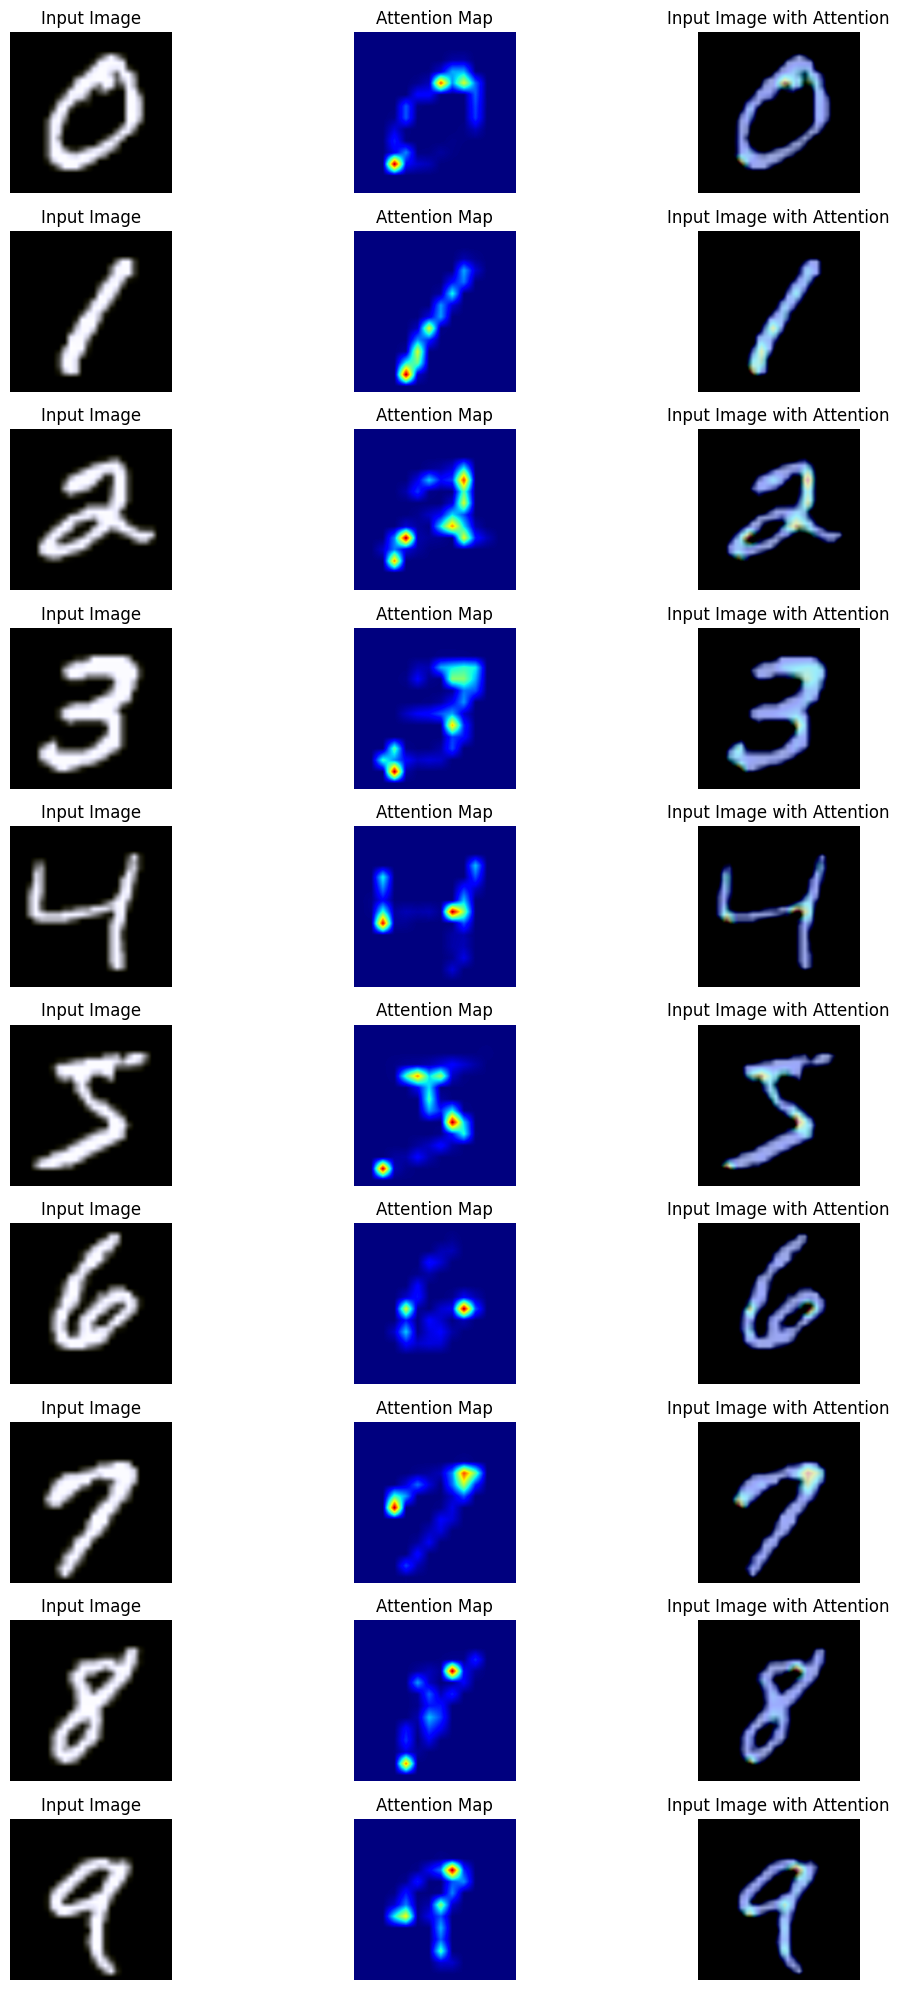

In [16]:
%run ./visualization.ipynb